In [1]:
from collections import Counter
import pickle

import pandas as pd
import numpy as np
import scipy

from statsmodels.formula.api import ols

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, clear_output

%matplotlib inline

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Normalizer, StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, NMF, TruncatedSVD

from sklearn.cross_validation import StratifiedShuffleSplit, ShuffleSplit
from sklearn.metrics import log_loss, roc_auc_score

from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.svm import LinearSVC

from sklearn.ensemble import ExtraTreesClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

In [3]:
def read_info(file_name):
    result = []
    
    for line in file(file_name):
        key, value = line.strip().split('=')
        key = key.strip()
        value = value.strip().strip("'")
        if value.isdigit():
            value = int(value)
        result.append((key, value))
    
    return dict(result)

In [4]:
public = read_info('data/set2_flora/flora_public.info')
public

{'feat_num': 200000,
 'feat_type': 'Numerical',
 'has_categorical': 0,
 'has_missing': 0,
 'is_sparse': 1,
 'label_num': 0,
 'metric': 'a_metric',
 'name': 'flora',
 'target_num': 1,
 'target_type': 'Numerical',
 'task': 'regression',
 'test_num': 2000,
 'time_budget': 1200,
 'train_num': 15000,
 'usage': 'AutoML challenge 2014',
 'valid_num': 2000}

In [5]:
ls data/set2_flora/

data.pickle      flora_public.info  flora_train.data      flora_valid.data
flora_feat.type  flora_test.data    flora_train.solution


In [6]:
dim = public['feat_num']

def read_sparse_features(fine_name):
    result = list()
    for line in file(fine_name):
        row = []
        for el in line.strip().split(' '): 
            pos, value = el.split(':')
            pos = int(pos) - 1
            row.append((pos, float(value)))
        result.append(row)

    rnum = len(result)
    X = scipy.sparse.dok_matrix((rnum, dim), dtype=np.float)
    for idx, row in enumerate(result):
        for pos, val in row:
            X[idx, pos] = val

    return scipy.sparse.csr_matrix(X)

In [7]:
from libscores import a_metric

In [8]:
X, y, X_valid, X_test = pickle.load(open('data/set2_flora/data.pickle', 'rb'))

X = read_sparse_features('data/set2_flora/flora_train.data')
y = np.fromfile('data/set2_flora/flora_train.solution', sep='\n', dtype=np.float)

X_valid = read_sparse_features('data/set2_flora/flora_valid.data')
X_test  = read_sparse_features('data/set2_flora/flora_test.data')

print X.shape, y.shape
print X_valid.shape, X_test.shape

pickle.dump([X, y, X_valid, X_test], open('data/set2_flora/data.pickle', 'wb'))

X = norm.fit_transform(X)
X_valid = norm.transform(X_valid)
X_test = norm.transform(X_test)

In [9]:
rows, cols = X.nonzero()
per_col_count = np.bincount(cols)

X = X[:, per_col_count > 5]
X_valid = X_valid[:, per_col_count > 5]
X_test = X_test[:, per_col_count > 5]

In [10]:
scaler = StandardScaler(with_mean=False, copy=False)
X = scaler.fit_transform(X)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Learning curves

In [191]:
n_iter = 5
cv = ShuffleSplit(len(y), n_iter=n_iter, test_size=0.25, random_state=1)

scores = []
it = 1
for train, test in cv:
    print 'iteration %d' % it

    model = Lasso()

    X_train = X[train]
    y_train = y[train]
    N, d = X_train.shape

    sample_size = list(range(1000, N, 1000)) + [N]
    for j in tqdm(sample_size):
        model.fit(X_train[:j], y_train[:j])
        y_pred = model.predict(X[test])

        score = a_metric(y[test], y_pred)
        scores.append((it, j, score))

    it = it + 1
clear_output()

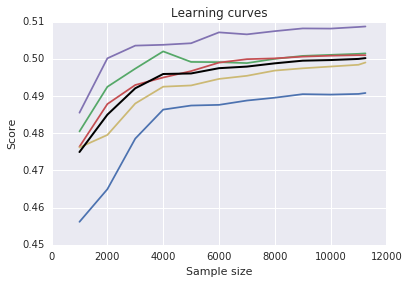

In [125]:
learning = pd.DataFrame(scores, columns=['it', 'sample_size', 'score'])

for it, grp in learning.groupby('it'):
    plt.plot(grp.sample_size, grp.score)

mean_score = learning.groupby('sample_size').score.mean()
plt.plot(mean_score.index, mean_score.values, color='black', linewidth=2)

plt.title('Learning curves')
plt.xlabel('Sample size')
plt.ylabel('Score')

plt.show()

In [11]:
X_input = X

In [12]:
results = []

In [13]:
models = {
    'lasso': Lasso()
}

params = {
    'cv_train_size': 0.8,
    'model': 'lasso'
}

pipeline = Pipeline([
    ('model', models[params['model']])
])

pipe_params = {
    'model__alpha': 0.0085,
}

pipeline.set_params(**pipe_params)

n_iter = 5
cv = ShuffleSplit(len(y), n_iter=n_iter, train_size=params['cv_train_size'], random_state=1)

scores = []
for train, test in tqdm(cv):
    pipeline.fit(X_input[train], y[train])

    y_pred = pipeline.predict(X_input[test])
    score = a_metric(y[test], y_pred)

    scores.append(score)

params.update(pipe_params)
results.append((params, np.mean(score), np.std(score)))
print np.mean(score), np.std(score)

0.49847365522 0.0


In [14]:
lasso = models['lasso']
(lasso.coef_ > 0).sum()

252

In [15]:
for p, s, std in reversed(results[-5:]):
    print u'score: %0.5f ± %0.5f, params: %s' % (s, std, p)

score: 0.49847 ± 0.00000, params: {'model': 'lasso', 'model__alpha': 0.0085, 'cv_train_size': 0.8}


In [16]:
pipeline.fit(X, y)

Pipeline(steps=[('model', Lasso(alpha=0.0085, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [17]:
y_valid_score = pipeline.predict(X_valid)
y_test_score = pipeline.predict(X_test)


In [18]:
np.savetxt('submission/flora_valid.predict', y_valid_score, fmt='%0.10f')
np.savetxt('submission/flora_test.predict', y_test_score, fmt='%0.10f')